# Tutorial 2, Alignment of spatial transcriptomics and translatomics of the mouse brain

In [1]:
import sys
sys.path.append(r"/home/wangheqi/PycharmProject/")

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import torch

import matplotlib.pyplot as plt
import spcoral

### Read the data

The STAR and RIBO data can be download from https://singlecell.broadinstitute.org/single_cell/study/SCP1835.

We used the 5th dataset as the input to test alignment module of SPCoral.

In [2]:
adata_STAR = sc.read_h5ad('/csb3/project/wangheqi_meta/data/PMID39294367/adata_STAR_5_test.h5ad')
adata_RIBO = sc.read_h5ad('/csb3/project/wangheqi_meta/data/PMID39294367/adata_RIBO_5_test.h5ad')

In [3]:
adata_STAR = adata_STAR[adata_STAR.obs['replicate'] == 'rep2', :]

In [4]:
adata_STAR.X = adata_STAR.layers['raw']
adata_RIBO.X = adata_RIBO.layers['raw']

### Preprocess multi-omics data

In [5]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_STAR)
# Logarithmize the data
sc.pp.log1p(adata_STAR)

sc.pp.highly_variable_genes(adata_STAR, flavor='seurat_v3', n_top_genes=1000)
adata_STAR = adata_STAR[:, adata_STAR.var['highly_variable'] == True].copy()

In [6]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_RIBO)
# Logarithmize the data
sc.pp.log1p(adata_RIBO)

sc.pp.highly_variable_genes(adata_RIBO, flavor='seurat_v3', n_top_genes=1000)
adata_RIBO = adata_RIBO[:, adata_RIBO.var['highly_variable'] == True].copy()

In [7]:
# selected preprocessed data as the input
adata_STAR.obsm['feat'] = adata_STAR.X
adata_RIBO.obsm['feat'] = adata_RIBO.X

### Model training

In [8]:
Model = spcoral.model.regist_model(
    adata_omics1 = adata_STAR,
    adata_omics2 = adata_RIBO,
    graph_method = 'radius',
    n_layer=[1, 3, 5, 7, 9, 11, 13, 15],
    radius_spatial_omics1 = 500,
    radius_spatial_omics2 = 500,
    alpha = 0.1,
    epochs=200,
    random_seed=2030,
    device = torch.device('cuda:0')
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


In [9]:
adata_STAR, adata_RIBO, loss_list = Model.train()
adata_STAR, registering_parameters = spcoral.model.registration(
    adata_STAR, adata_RIBO, n_iter=10, beta=0.9, method='rigid'
)

[Fast Mode] Seed=2030, cudnn.benchmark=True, multi-thread ON


Training: 100%|████████████████████████████████████████████████████████████████████████████| 200/200 [03:28<00:00,  1.04s/it]


The number of anchors is 750


### Visualization of output

<Axes: title={'center': 'SPCoral Alignment'}, xlabel='spatial1', ylabel='spatial2'>

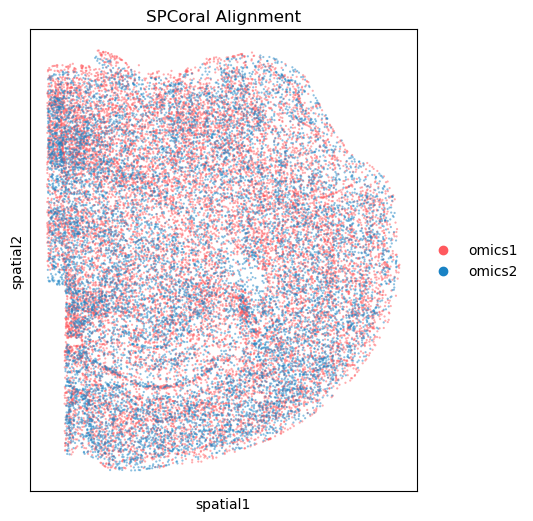

In [10]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 6), dpi=100)

spcoral.plot.show_cross_align(
    adata_STAR, adata_RIBO,
    omics1_use_obsm='spatial_reg', 
    omics2_use_obsm='spatial',
    ax=ax,
    size_omics1=10,
    size_omics2=10,
    alpha_omics1=0.5,
    alpha_omics2=0.5,
    title='SPCoral Alignment',
    show=False
)

In [11]:
palette = {
    'Cerebal nuclei': '#1f77b4',
    'Cortical subplate': '#ff7f0e',
    'Fiber tracts': '#2ca02c',
    'Hippocampal region': '#d62728',
    'Hypothalamus': '#9467bd',
    'Isocortex': '#8c564b',
    'Olfactory areas': '#bcbd22',
    'Thalamus': '#e377c2',
    'other': '#7f7f7f',
}

dataset1: 9 cell types; dataset2: 9 cell types; 
                    Total :9 celltypes; Overlap: 9 cell types 
                    Not overlap :[[]]
Subsampled 300 pairs from 750


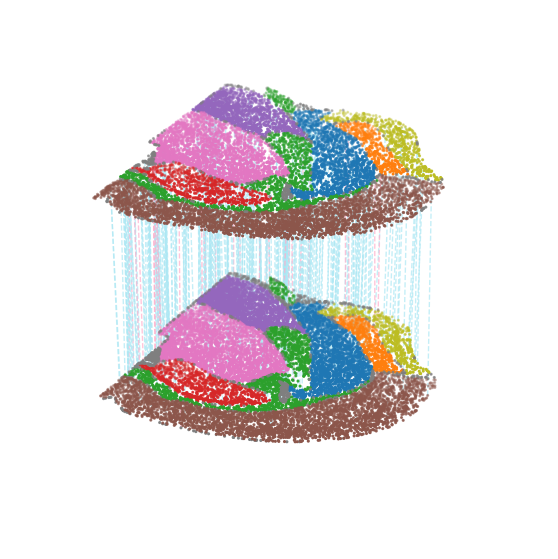

In [12]:
ax = spcoral.plot.show_cross_align_3D(adata_STAR, adata_RIBO, registering_parameters, color_based='region',color=palette,
                                 omics1_use_obsm='spatial_reg', omics2_use_obsm='spatial', line_width=1, show=False)

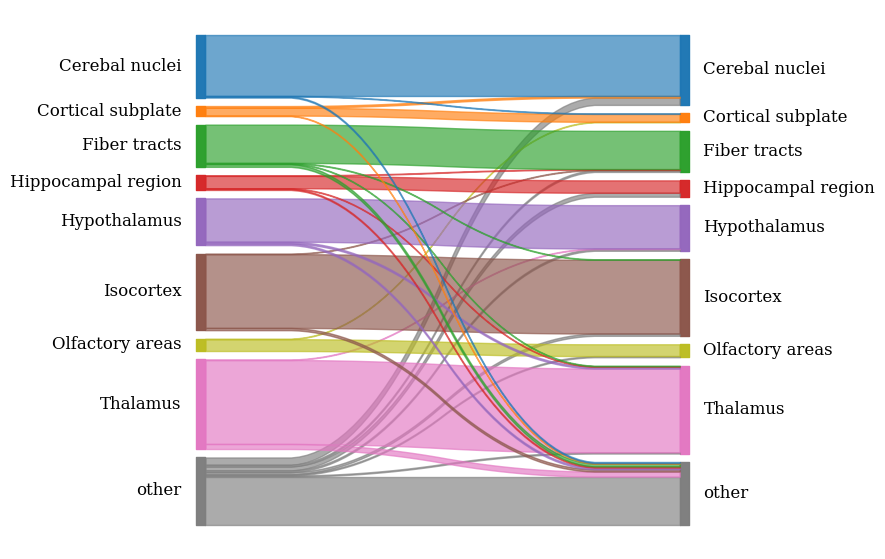

In [13]:
%matplotlib inline

leftLabels = ['other', 'Thalamus', 'Olfactory areas', 'Isocortex', 'Hypothalamus',
              'Hippocampal region', 'Fiber tracts', 'Cortical subplate', 'Cerebal nuclei']
rightLabels = ['other', 'Thalamus', 'Olfactory areas', 'Isocortex', 'Hypothalamus',
              'Hippocampal region', 'Fiber tracts', 'Cortical subplate', 'Cerebal nuclei']

ax = spcoral.plot.show_cross_anchor_Sankey(adata_STAR, adata_RIBO, registering_parameters, celltype_label='region', color_map=palette,
                                           show=False, leftLabels=leftLabels, rightLabels=rightLabels
                                     )